<a href="https://colab.research.google.com/github/RPGraciotti/BootCampAlura/blob/main/Modulo_2/Aula_6_Agrupando_dados_e_analisando_por_categoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import seaborn as sns
from datetime import date

df = pd.read_csv("https://raw.githubusercontent.com/RPGraciotti/agendamento-hospitalar/main/dados/A160324189_28_143_208.csv", encoding = "ISO-8859-1",
                 skiprows = 3, sep = ";", skipfooter = 12,
                 thousands = ".", decimal = ",", engine = "python")
pd.options.display.float_format = "{:.2f}".format
use_col = df.mean().index.tolist()
use_col.insert(0, "Unidade da Federação")
use = df.loc[:,use_col]
use = use.set_index("Unidade da Federação")
use.sort_values(by = "Total") # crescente
total_ord = use.sort_values(by = "Total", ascending = False) # decrescente
total_ord = total_ord.drop("Total", axis = 1)
main_cols = total_ord.columns[6:]
total_ord = total_ord[main_cols]
total_ord = total_ord/1000000
total_ord.index = total_ord.index.str[3:] # Matar esse problema aqui de vez
ultimo_mes = total_ord.columns[-1]
gastos_ultimo_mes = total_ord[ultimo_mes]
gastos_prop_estado = gastos_ultimo_mes / gastos_ultimo_mes.sum()
tabelas_wiki = pd.read_html("https://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_popula%C3%A7%C3%A3o")
dados_populacao_raw = tabelas_wiki[0]
dados_populacao_raw

def limpeza(df1, df2):
  """limpeza, tratamento e join de dados"""
  df1 = df1.dropna().copy()
  df1.columns = ["posicao", "uf", "populacao", "porc", "pais"]
  df1.loc[:,"populacao"] = pd.to_numeric(df1.loc[:,"populacao"].str.replace(" ",""))
  df1 = df1.loc[:,["populacao", "uf"]]
  df1 = df1.set_index("uf")
  df1.index = df1.index.str.strip()

  for i in df2.index:
    df1.index = df1.index.str.replace(f"{i} {i}", i)

  return df1.join(df2)

gastos_e_populacao_recente = limpeza(dados_populacao_raw, gastos_ultimo_mes)

def insere_gastos_e_gasto_por_habitante_para(todos_os_gastos: pd.DataFrame, dados: pd.DataFrame, mes: str): 
  # mes: str define que o tipo de mes só pode ser string
  # pd.DataFrame para definir que só pode ser DataFrame
  gastos_do_mes = todos_os_gastos.loc[:,mes]
  dados.loc[:, f"gastos_{mes}"] = gastos_do_mes * 1000000
  dados.loc[:, f"gasto_por_habitante_{mes}"] = dados.loc[:, f"gastos_{mes}"] / dados.loc[:, "populacao"]

mensal = total_ord.T

# criando dicionario

meses = {
    "Jan" : 1,
    "Fev" : 2,
    "Mar" : 3,
    "Abr" : 4,
    "Mai" : 5,
    "Jun" : 6,
    "Jul" : 7,
    "Ago" : 8,
    "Set" : 9,
    "Out" : 10,
    "Nov" : 11,
    "Dez" : 12
}

def para_dia(ano_mes: str):
  ano: int = int(ano_mes[:4])
  mes: str = ano_mes[5:]
  mes_numero: int = meses[mes]
  return date(ano, mes_numero, 1)

mensal.index = mensal.index.map(para_dia)

mensal_aberto = mensal.reset_index().melt(id_vars = ["index"], value_vars = mensal.columns)
mensal_aberto.columns = ["mes", "uf", "gasto"]

mensal_aberto.columns = ["dia_mes_ano", "uf", "gasto"]
mensal_aberto.loc[:,"dia_mes_ano"] = mensal_aberto.loc[:,"dia_mes_ano"].astype("datetime64")

mensal_aberto.loc[:,"mes"] = mensal_aberto.loc[:,"dia_mes_ano"].dt.month
mensal_aberto.loc[:,"ano"] = mensal_aberto.loc[:,"dia_mes_ano"].dt.year


inv_meses = {v: k for k, v in meses.items()} # aqui precisaremos fazer a conversão contrária do que foi feito antes, invertendo o dicionário
mensal_aberto.loc[:,"mes_str"] = mensal_aberto.loc[:,"mes"].map(inv_meses)
mensal_aberto.loc[:,"mes_str"] = pd.Categorical(mensal_aberto.loc[:,'mes_str'],["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", "Jul", "Ago", "Set", "Out", "Nov", "Dez"])

dias_por_mes = {
    1 : 31,
    2 : 28,
    3 : 31,
    4 : 30,
    5 : 31,
    6 : 30,
    7 : 31,
    8 : 31,
    9 : 30,
    10 : 31,
    11 : 30,
    12 : 31
}

mensal_aberto.loc[:, "gasto_diario"] = mensal_aberto.loc[:, "gasto"] / mensal_aberto.loc[:,"mes"].map(dias_por_mes)

In [2]:
mensal_aberto.head()

,dia_mes_ano,uf,gasto,mes,ano,mes_str,gasto_diario
0,2008-02-01,São Paulo,172.83,2,2008,Fev,6.17
1,2008-03-01,São Paulo,170.48,3,2008,Mar,5.50
2,2008-04-01,São Paulo,170.28,4,2008,Abr,5.68
3,2008-05-01,São Paulo,172.40,5,2008,Mai,5.56
4,2008-06-01,São Paulo,175.42,6,2008,Jun,5.85


In [3]:
estado_a_analisar = mensal_aberto.query("uf == 'São Paulo'")

estado_a_analisar.head()

,dia_mes_ano,uf,gasto,mes,ano,mes_str,gasto_diario
0,2008-02-01,São Paulo,172.83,2,2008,Fev,6.17
1,2008-03-01,São Paulo,170.48,3,2008,Mar,5.50
2,2008-04-01,São Paulo,170.28,4,2008,Abr,5.68
3,2008-05-01,São Paulo,172.40,5,2008,Mai,5.56
4,2008-06-01,São Paulo,175.42,6,2008,Jun,5.85


In [4]:
gastos_por_ano = estado_a_analisar.groupby("ano").sum()

In [5]:
gastos_por_ano.head()

,gasto,mes,gasto_diario
ano,,,
2008,1960.23,77,64.60
2009,2489.03,78,81.82
2010,2696.62,78,88.63
2011,2794.55,78,91.91
2012,2873.97,78,94.47


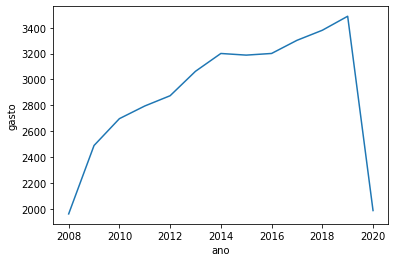

In [10]:
sns.lineplot(data = gastos_por_ano, x = gastos_por_ano.index, y = "gasto")
# arrumar limite

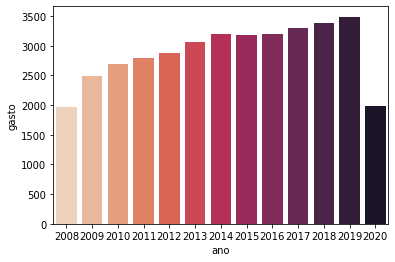

In [15]:
sns.barplot(data = gastos_por_ano, x = gastos_por_ano.index, y = "gasto", 
            palette = sns.color_palette("rocket_r", 13))

## Desafio: tom de cor ordenado PELO VALOR
"A cor passa uma mensagem nova ou reforça uma mensagem que queremos reforçar"

In [18]:
estados = ["São Paulo", "Minas Gerais", "Pernambuco"]
estados_por_ano = mensal_aberto.query("uf in @estados").groupby(["uf", "ano"]).sum().reset_index()

In [19]:
estados_por_ano.head()

,uf,ano,gasto,mes,gasto_diario
0,Minas Gerais,2008,894.35,77,29.44
1,Minas Gerais,2009,1149.14,78,37.77
2,Minas Gerais,2010,1217.49,78,40.03
3,Minas Gerais,2011,1315.02,78,43.24
4,Minas Gerais,2012,1408.35,78,46.29


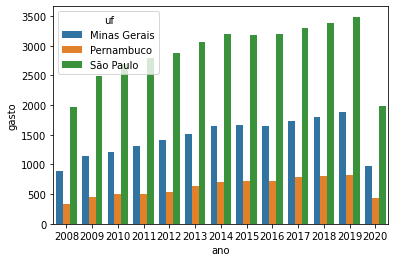

In [23]:
sns.barplot(data = estados_por_ano, x = "ano", y = "gasto", hue = "uf")

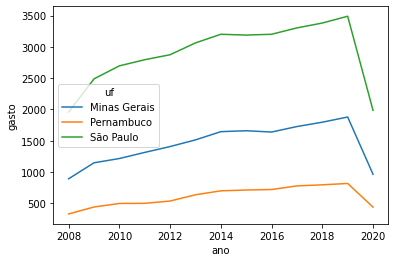

In [27]:
sns.lineplot(data = estados_por_ano, x = "ano", y = "gasto", hue = "uf")

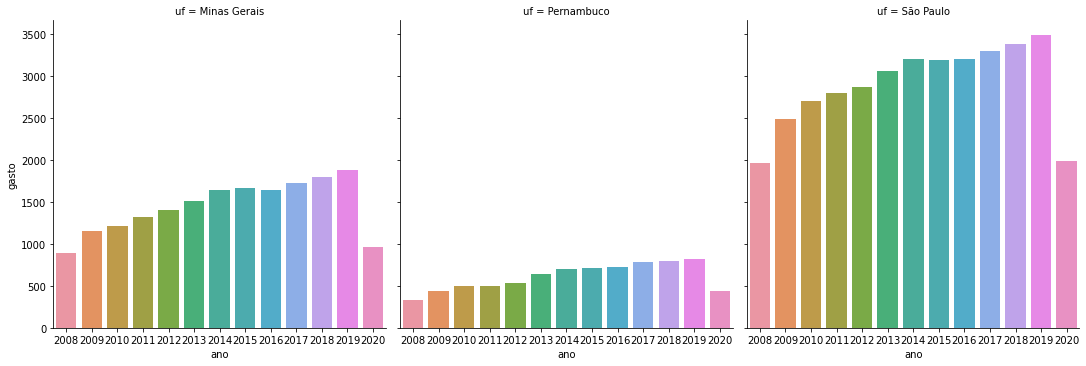

In [25]:
sns.catplot(data = estados_por_ano, x = "ano", y = "gasto", kind = "bar", col = "uf")

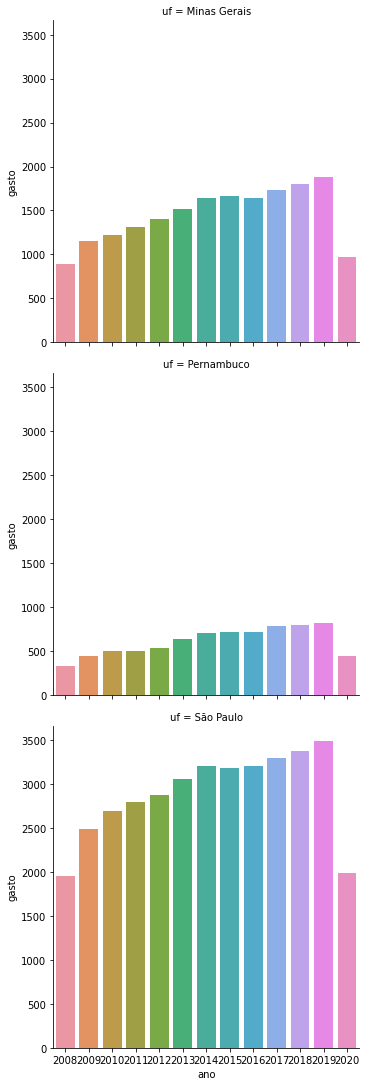

In [29]:
sns.catplot(data = estados_por_ano, x = "ano", y = "gasto", kind = "bar", row = "uf")